In [1]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

'''
Read the data
'''
df = pd.read_csv('jakobshavn.csv',na_values=[-1])

'''
Build the pipeline
'''
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [13]:
# Ensure df['Date'] is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define the percentage of data to be used for training
alpha = 0.01  # Example: use 95% of the data for training and 5% for evaluation

# Number of time series to forecast
n_timeseries = 100  # You can set this to the number of columns you want to forecast

# Select the first n_timeseries columns for forecasting
columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

# Calculate the split index for training
split_index = int(len(df) * (1 - alpha))

# Split the data into training and evaluation sets for all selected columns
train_data = df[columns_to_forecast].iloc[:split_index]
eval_data = df[columns_to_forecast].iloc[split_index:]

# Convert the training data to a higher-dimensional tensor
train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T

# Perform the forecasting using the training data
forecast = pipeline.predict(
    context=train_tensor,
    prediction_length=len(eval_data),  # Predict the same length as the evaluation set
    num_samples=50,
)

# Take the mean across the samples (axis=1) for each time series
forecast_mean = forecast.mean(dim=1).squeeze()


In [14]:
mae=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae.append (np.mean(np.abs(forecast_mean[i].numpy() - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'Mean Absolute Error (MAE) for {column_name}: {mae[-1]}')

print(f'Mean of forecast MAEs = {np.array(mae).mean()}')

mae_nochangemodel=[]
# Calculate and print the MAE for each time series
for i, column_name in enumerate(columns_to_forecast):
    # Calculate MAE for the current time series
    mae_nochangemodel.append (np.mean(np.abs(eval_data[column_name].values[-1] - eval_data[column_name].values)))
    
    # Print the MAE
    # print(f'MAE assuming d/dt=0 for {column_name}: {mae_nochangemodel[-1]}')

print(f'Mean of d/dt=0 MAEs = {np.array(mae_nochangemodel).mean()}')

Mean of forecast MAEs = 63.69416218359373
Mean of d/dt=0 MAEs = 28.9624494


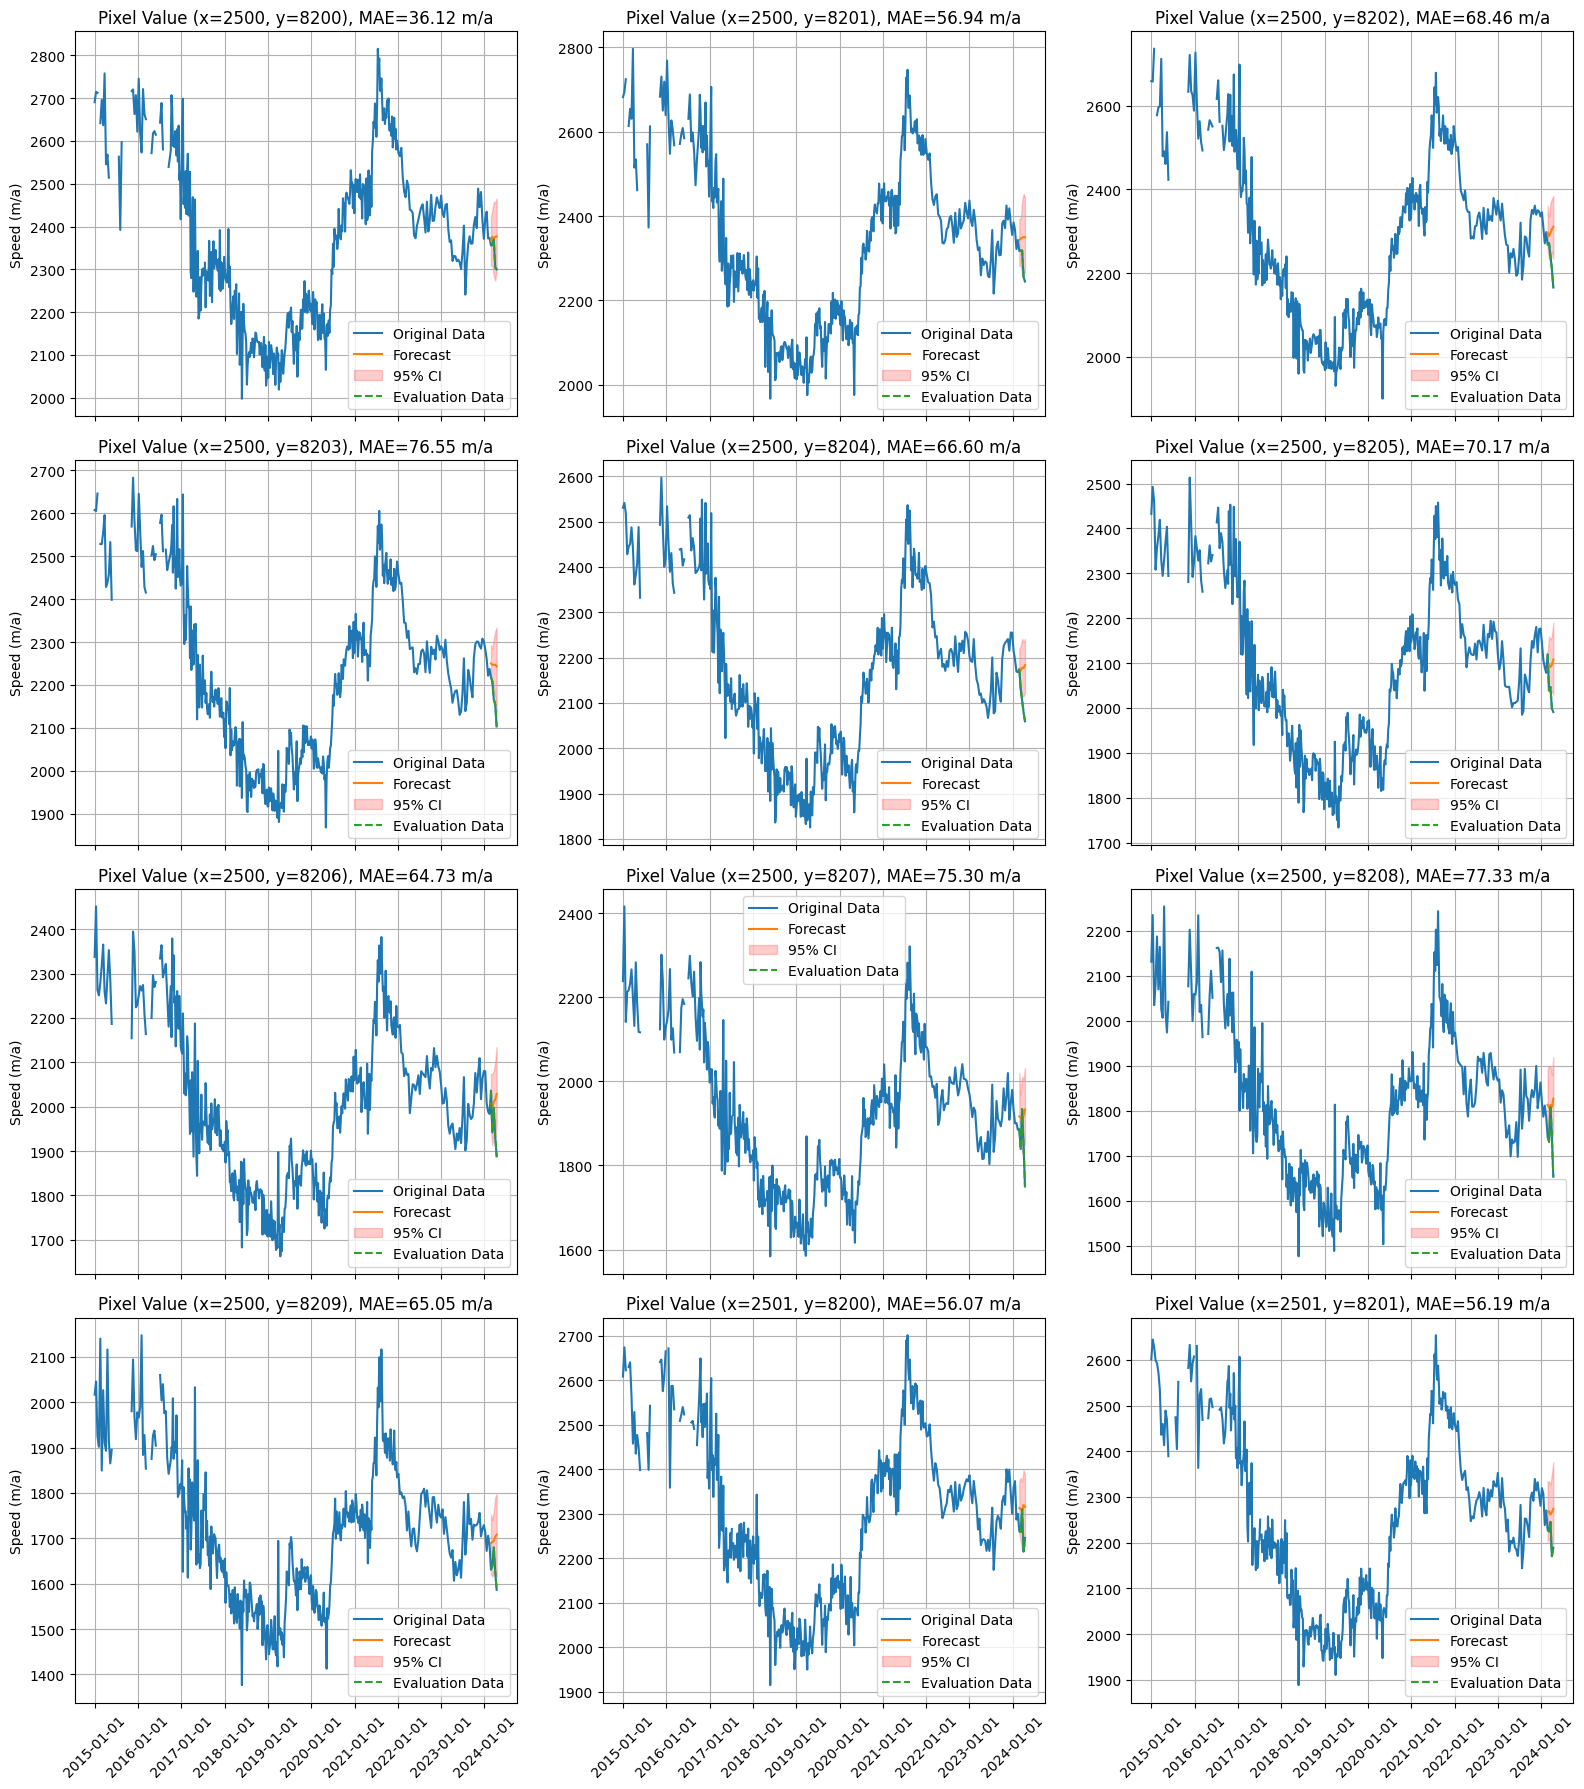

In [15]:
# Determine the layout: 4 rows by 2 columns
nrows, ncols = 4, 3

# Create a nrows-by-ncols grid of subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 18), sharex=True)

# Flatten the 2D array of axes for easy indexing
axes = axes.flatten()

# Iterate over the first n_timeseries and plot
for i, column_name in enumerate(columns_to_forecast[0:12]):
    # Plot the original data
    axes[i].plot(df['Date'], df[column_name], label='Original Data')
    
    # Calculate the 5th and 95th percentiles for the confidence interval
    lower_bound = np.percentile(forecast[i, :, :].numpy(), 5, axis=0)
    upper_bound = np.percentile(forecast[i, :, :].numpy(), 95, axis=0)
    
    # Plot the forecast
    axes[i].plot(df['Date'].iloc[split_index:], forecast_mean[i].numpy(), label='Forecast')
    
    # Plot the confidence intervals
    axes[i].fill_between(df['Date'].iloc[split_index:], lower_bound, upper_bound, 
                         color='r', alpha=0.2, label='95% CI')

    # Plot the evaluation data for reference
    axes[i].plot(df['Date'].iloc[split_index:], eval_data[column_name].values, '--', label='Evaluation Data')

    # Format the subplot
    axes[i].set_title(f'{column_name}, MAE={mae[i]:.2f} m/a')
    axes[i].set_ylabel('Speed (m/a)')
    axes[i].grid(True)
    axes[i].legend()

    # Apply x-tick rotation
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots if n_timeseries < 8
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('jakobshavn-forecast.png')
plt.show()